In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

In [5]:
with open('reviews.json') as json_data:
    da = json.load(json_data)
    review_df = pd.DataFrame(da)

In [6]:
# we only need review after 2017-01-01
review_df.date = pd.to_datetime(review_df.date)
review_df=review_df[review_df['date']>='2017-01-01']

In [7]:
# transform the rate into numeric variables
for i in range(len(review_df.rate)):
    review_df.iloc[i,4]=review_df.rate[i][:3]
    review_df.iloc[i,6]=review_df.review_format[i][7:]

In [8]:
review_df.rate = review_df.rate.astype(float).fillna(0.0)

In [9]:
# take a look at the data
review_df.head()

,author,date,declarative,image,rate,review_body,review_format,review_title
0,Ryan Shi,2018-04-03,Verified Purchase,False,5.0,"small in size, good quality, bright enough. Th...",Black,"good quality, bright enough"
1,Fran Dux,2018-04-03,Verified Purchase,False,2.0,The zoom does not work on any of the flashligh...,4 Pack,I do not recommend this flashlight
2,CHENGCHEN,2018-04-02,Verified Purchase,False,5.0,These were great and worth every penny.,Black,Five Stars
3,Cindy,2018-03-31,Verified Purchase,False,5.0,This is a great mini flashlights! The size is ...,Black,This is a great mini flashlights
4,Andrew,2018-03-31,Verified Purchase,False,5.0,"Little cute flesh lights! Love it. Small , han...",Black,Love it. Small


In [10]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761 entries, 0 to 760
Data columns (total 8 columns):
author           761 non-null object
date             761 non-null datetime64[ns]
declarative      761 non-null object
image            761 non-null bool
rate             761 non-null float64
review_body      761 non-null object
review_format    761 non-null object
review_title     761 non-null object
dtypes: bool(1), datetime64[ns](1), float64(1), object(5)
memory usage: 68.3+ KB


## Content
- I mainly performed logistic regression and SVM on the scraped data and made analysis on the results of both methods.
- In order to improve the performance of the algorithms, I tried SMOTE and feature selection. But they didn't improve the accuracy of the models for some reason.
- The content of this assignment is listed as below:
     1. EDA
     2. Preprocessing method
     3. Build the model
     4. Algorithm analysis
     5. Attachment (Other methods)

# 1. EDA of the Amazon review dataset for Flashlights.

## 1.1 Histogram of rates and insights from whether having images in the review or not.
 - Most of the rates are 5, and only few comments have images.
 - This is a imbalanced dataset.
 - people updated images of the product tends to give high rate score as well.

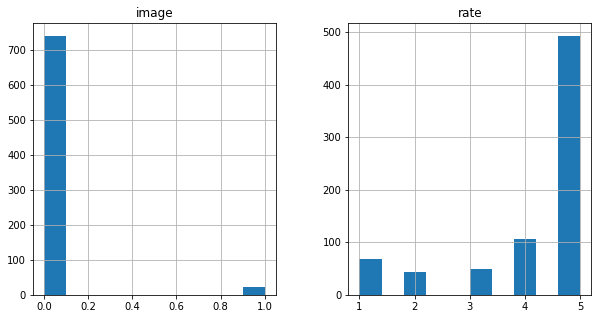

5.0    493
4.0    107
1.0     68
3.0     49
2.0     44
Name: rate, dtype: int64
False    739
True      22
Name: image, dtype: int64


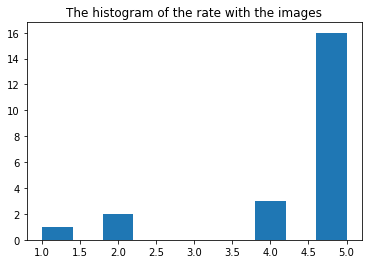

5.0    16
4.0     3
2.0     2
1.0     1
Name: rate, dtype: int64


In [11]:
%matplotlib inline
# histogram of the Amazon data
import matplotlib.pyplot as plt
review_df.hist(figsize=(10,5))
plt.show()
print(review_df.rate.value_counts())
print (review_df.image.value_counts())
image_review = review_df[review_df.image==True]
plt.hist(image_review.rate)
plt.title('The histogram of the rate with the images')
plt.show()
print(image_review.rate.value_counts())

-  **Insight from products formats information (Black, 4-pack, and 6-pack)**
- Most of the customers bought black and only few of them bought 4-pack and 6-pack. 
- Customers bought 4-pack and 6-pack product tend to give high review score.

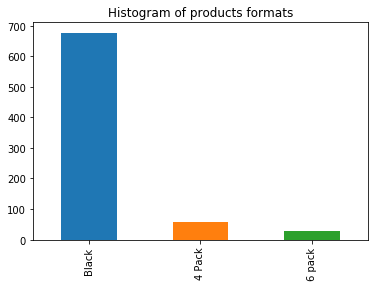

Black     677
4 Pack     57
6 pack     27
Name: review_format, dtype: int64

In [12]:
review_df.review_format.value_counts().plot('bar')
plt.title('Histogram of products formats')
plt.show()
review_df.review_format.value_counts()

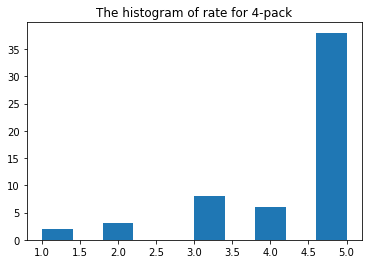

5.0    38
3.0     8
4.0     6
2.0     3
1.0     2
Name: rate, dtype: int64


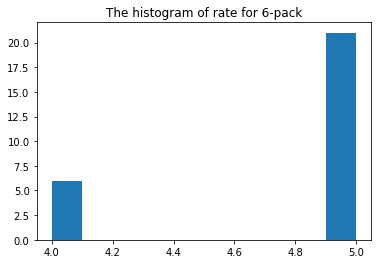

5.0    21
4.0     6
Name: rate, dtype: int64


In [13]:
pack4_review = review_df[review_df.review_format=='4 Pack']
plt.hist(pack4_review.rate)
plt.title('The histogram of rate for 4-pack')
plt.show()
print(pack4_review.rate.value_counts())
pack6_review = review_df[review_df.review_format=='6 pack']
plt.hist(pack6_review.rate)
plt.title('The histogram of rate for 6-pack')
plt.show()
print(pack6_review.rate.value_counts())

## 1.2 Analyzing Authors' names of the review to check if spammers exist. 

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
cv = CountVectorizer(lowercase=True, max_features=30)
data_name = cv.fit_transform(review_df.author)
#data_name.toarray()
uniname_array = data_name.toarray()
print ('First 30 the most frequent unigrams in the reviewers\'s name:')
print (cv.get_feature_names())
print ('\nHow many times they appears:')
print (uniname_array.sum(axis=0))

First 30 the most frequent unigrams in the reviewers's name:
['aaron', 'amazon', 'charles', 'chris', 'customer', 'dan', 'daniel', 'david', 'de', 'douglas', 'ed', 'edward', 'eric', 'george', 'james', 'john', 'josh', 'jr', 'mark', 'mary', 'michael', 'mike', 'of', 'richard', 'robert', 'ryan', 'smith', 'the', 'tom', 'william']

How many times they appears:
[ 3 82  5  6 85  3  4  5  5  4  3  5  5  5  9  7  3  3  3  3 11  6  3  8
  9  5  3  4  4  5]


In [16]:
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(2, 2), max_features=30)
data_name_bigram = cv.fit_transform(review_df.author)
biname_array = data_name_bigram.toarray()
#print(data_name_bigram.toarray())
print ('First 30 the most frequent bigrams in the reviewers\'s name:')
print (cv.get_feature_names())
print ('\nHow many times they appears:')
print (biname_array.sum(axis=0))

First 30 the most frequent bigrams in the reviewers's name:
['201 escape', 'amazon customer', 'cliente amazon', 'miguel arellano', 'miguel niño', 'mike holmes', 'miller jr', 'mohand reyyashi', 'mohit gangwani', 'mr charles', 'ms dee', 'ms dimas', 'natalie sanchez', 'nelson jr', 'nic ng', 'nicholas caporusso', 'nicole friez', 'nikki sotelo', 'niño lara', 'norman avelenda', 'omar lopez', 'pablo caballero', 'paun marin', 'peggy lightner', 'penny lane', 'pete felicijan', 'peter dandyk', 'philip sinson', 'phoenix ikki', 'picky nancy']

How many times they appears:
[ 1 80  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]


In [17]:
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(3, 3))
data_name_bigram = cv.fit_transform(review_df.author)
biname_array = data_name_bigram.toarray()
#print(data_name_bigram.toarray())
print ('The most frequent trigrams in the reviewers\'s name:')
print (cv.get_feature_names())
print ('\nHow many times they appears:')
print (biname_array.sum(axis=0))

The most frequent trigrams in the reviewers's name:
['201 escape room', 'amazon customer k4gwg', 'butta yehonatan yaakove', 'caroline dai prá', 'cattle dog lady', 'charles boy jr', 'crazy cattle dog', 'customer k4gwg gmail', 'dee burdick desanti', 'dr lrf dpt', 'george miller jr', 'james yelle sr', 'jesus la torre', 'k4gwg gmail om', 'luis miguel niño', 'miguel niño lara', 'mr charles keiper', 'red shoe lover', 'reyes eli banda', 'robert nelson jr', 'spaniel luver todd', 'suite 201 escape', 'wade alexander wright', 'wi farm family', 'william lee hannibal', 'william van nostrand']

How many times they appears:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [18]:
# group by names 
# show the replicated names
counts = review_df.groupby('author').size()
df2 = pd.DataFrame(counts, columns = ['size'])
df2[df2['size']>1]

,size
author,
Aaron,2
Amazon Customer,78
Andrew,2
B,2
CJ,2
Chris,4
Cliente de Amazon,2
Dan,2
Eric,4


### Findings from the authors' name length: 
- As it can be seen from the above analysis, there are many authors' names starting with **Amazon customer** (there are 78 in totoal). It might be possible that some of them are spammers.
- The next step is to check if they are spammers who would usually give very high rate without useful/meaningful comments.
- Also, I will check if there are spammers existing in other name categories (i.e. bigram and unigram).

### First, check users with user name of 'Amazon Customer'.
- As it can be seen from the below analysis, the reviews are pretty simple but with clear opinion to some extent from these customers, and there might have some fake reviews in this 'Amazon Customer' subset but I don't think there will be many.

In [19]:
# First, we should check the replicated name 'Amazon Customer' to see if there are fake reviews from these users.
index_amazon = []
for i in range(len(review_df.author)):
    if review_df.iloc[i, 0].startswith('Amazon'):
        index_amazon.append(i)
df_new = review_df.loc[index_amazon, :]
df_new.head()

,author,date,declarative,image,rate,review_body,review_format,review_title
12,Amazon Customer,2018-03-25,Verified Purchase,False,5.0,"A perfect flashlight,it’s easy to carry .The l...",Black,"A perfect flashlight, it’s easy to carry"
15,Amazon Customer,2018-03-20,Verified Purchase,False,5.0,These small LED flashlights are wonderful! Sm...,Black,Five Stars
23,Amazon Customer,2018-03-12,Verified Purchase,False,5.0,Excellent deal for a pair of probably most eff...,Black,Five Stars
50,Amazon Customer,2018-01-27,Verified Purchase,False,4.0,The best thing on this phone is that it is stu...,Black,Great small flashlight!
53,Amazon Customer,2018-01-25,Verified Purchase,False,3.0,These lights seem to have issues after a littl...,Black,Uhh


In [20]:
length = []
for i in range(len(df_new.author)):
    length_name = len(df_new.iloc[i, 0])
    length.append(length_name)

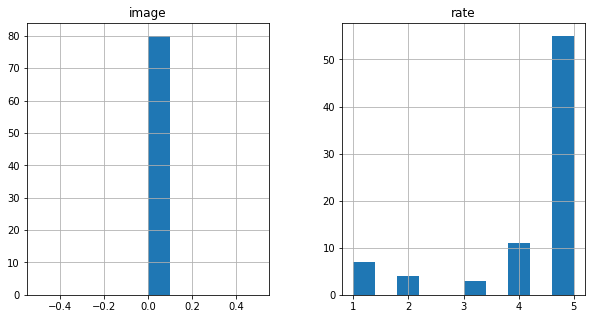

In [21]:
#plot histogram of the 'Amazon Customer'
df_new.hist(figsize=(10,5))
plt.show()
# these customers never update images of the products.

In [22]:
# If we only take users with name "amazon customer", rate >=5, and the review length < 10.
# It seems these customers are very possible some one-time customers, who only register to buy thing from Amazon 
# when they want this product or somebody doesn't have an Amazon account.
list_index = []
for i in range(len(df_new.review_body)):
    count = len(re.findall(r'\w+', df_new.iloc[i,5]))
    rate = df_new.iloc[i,4]
    if count<10 and rate>=4:
        list_index.append(i)
df_new.iloc[list_index, :].head()

,author,date,declarative,image,rate,review_body,review_format,review_title
57,Amazon Customer,2018-01-17,Verified Purchase,False,5.0,"GREAT little flashlights! Powerful, tough, in...",Black,"Powerful, tough, inexpensive"
92,Amazon Customer,2017-12-22,Verified Purchase,False,5.0,Very bright nice flashlight.,Black,Five Stars
138,Amazon Customer,2017-11-17,Verified Purchase,False,5.0,perfect little flashlights!,4 Pack,Love these cute little flashlights
174,Amazon Customer,2017-11-01,Verified Purchase,False,5.0,Awesome flashlights!,Black,Five Stars
181,Amazon Customer,2017-10-28,Verified Purchase,False,5.0,Great lights,Black,Five Stars


### Then, check users with one-word username and two-word username. 
- **Insight:**
- As it can be seen from the below analysis, some of the reviews' quality are pretty poor with only one word (e.g. Great, Good, etc.) from both categories. 
- Most of the users are using one-word username or two-word username in this Amazon Review dataset.
- And comparing to the previous analysis, it's more possible to have fake reviews from these two subsets.

In [23]:
# Get the histogram of the usernames' length.
cv = CountVectorizer(lowercase=True)
data_name = cv.fit_transform(review_df.author)
uniname_array = data_name.toarray()
name_array = uniname_array.sum(axis=1)

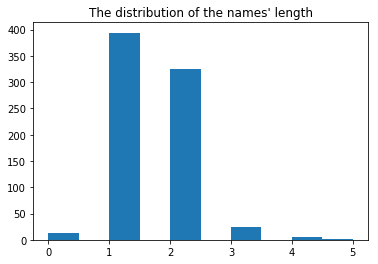

In [24]:
plt.hist(name_array)
plt.title('The distribution of the names\' length')
plt.show()
# most of the usernames are in 2 words or 3 words.

In [25]:
# get two seprate dataframe for one-word name and two-word name users.
two_name_customer = []
one_name_customer = []
for i in range(len(review_df.author)):
    count = len(re.findall(r'\w+', review_df.iloc[i,0]))
    if count == 2:
        two_name_customer.append(i)
    if count == 1:
        one_name_customer.append(i)
df_biname = review_df.loc[two_name_customer, :]
df_uniname = review_df.loc[one_name_customer, :]

In [26]:
review_length_biname = []
for i in range(len(df_biname.review_body)):
    #n_count = 
    count = len(re.findall(r'\w+', df_biname.iloc[i,5]))
    if count<10:
        list_index.append(i)
    review_length_biname.append(count)

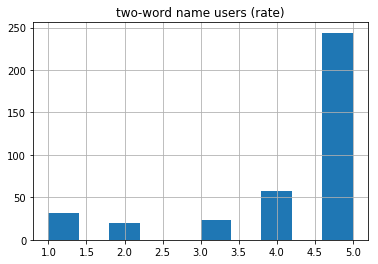

In [27]:
df_biname.rate.hist()
plt.title('two-word name users (rate)')
plt.show()

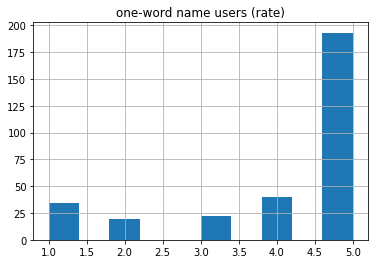

In [28]:
df_uniname.rate.hist()
plt.title('one-word name users (rate)')
plt.show()

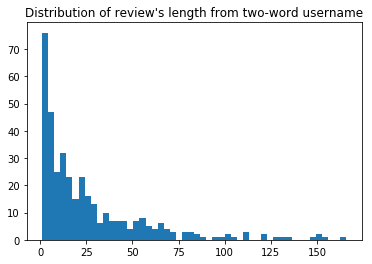

In [29]:
plt.hist(review_length_biname, bins=50)
plt.title('Distribution of review\'s length from two-word username')
plt.show()

In [30]:
# look at what two-word name user said about the product and the rate from them
list_index_two = []
for i in range(len(df_biname.review_body)):
    #n_count = 
    count = len(re.findall(r'\w+', df_biname.iloc[i,5]))
    rate = df_biname.iloc[i,4]
    if count<10 and rate>=4:
        list_index_two.append(i)
    #review_length_biname.append(count)

In [31]:
df_biname.iloc[list_index_two,:].head()

,author,date,declarative,image,rate,review_body,review_format,review_title
13,a.miller,2018-03-25,Verified Purchase,False,4.0,you get what pay for,Black,Four Stars
17,William Vuzzo,2018-03-18,Verified Purchase,False,5.0,These are great for work. Get the upgraded bat...,Black,Five Stars
20,Robert W.,2018-03-17,Verified Purchase,False,5.0,Works great.,6 pack,Five Stars
28,Hailing L.,2018-02-27,Verified Purchase,False,5.0,"works good, I used this during hurricane irma",Black,good
30,mohand reyyashi,2018-02-19,Verified Purchase,False,5.0,nice,Black,Five Stars


In [32]:
# look at what one-word name user said about the product and the rate from them
list_index_one = []
for i in range(len(df_uniname.review_body)):
    #n_count = 
    count = len(re.findall(r'\w+', df_uniname.iloc[i,5]))
    rate = df_uniname.iloc[i,4]
    if count<10 and rate >=4:
        list_index_one.append(i)
    #review_length_biname.append(count)

In [33]:
df_uniname.iloc[list_index_one,:].head()

,author,date,declarative,image,rate,review_body,review_format,review_title
2,CHENGCHEN,2018-04-02,Verified Purchase,False,5.0,These were great and worth every penny.,Black,Five Stars
10,Shelly,2018-03-27,Verified Purchase,False,5.0,"Small and exquisite, easy to carry around.",Black,easy to carry around
21,mdnike,2018-03-15,Verified Purchase,False,5.0,Great product,Black,Five Stars
22,PRT,2018-03-13,Verified Purchase,False,5.0,"GREAt, compact flashlight. Nice quality",Black,Five Stars
25,KBOWDRUMS,2018-03-10,Verified Purchase,False,5.0,Great little flashlights.,Black,Five Stars


## 1.3 Analyzing review and review title.

In [34]:
review_title = review_df.loc[:, 'review_title']
review_body = review_df.loc[:, 'review_body']

In [35]:
review_body.head()

0    small in size, good quality, bright enough. Th...
1    The zoom does not work on any of the flashligh...
2              These were great and worth every penny.
3    This is a great mini flashlights! The size is ...
4    Little cute flesh lights! Love it. Small , han...
Name: review_body, dtype: object

In [36]:
# to see the histogram of the length of the reviews
review_length = []
for i in range(len(review_body)):
    count = len(re.findall(r'\w+', review_body.loc[i]))
    review_length.append(count)

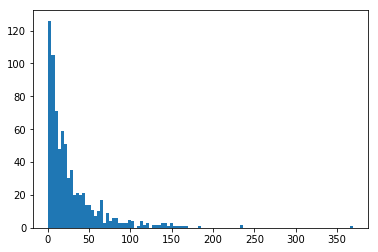

In [37]:
# the length of the review
plt.hist(review_length, bins =100)
plt.show() # most reviews are short, only few reviews are very long.

In [38]:
import spacy
nlp = spacy.load('en')

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin

In [40]:
class PartOfSpeechFilter(BaseEstimator, TransformerMixin):
    # must have the same name for the attributes, must has default, and must y = None.
    def __init__(self, pos_to_keep=('NOUN', 'PROPN', 'ADJ', 'VERB'), stop_words=None):
        self.pos_to_keep = pos_to_keep
        self.stop_words = stop_words
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        preprocessed_sentences = []
        
        for doc in nlp.pipe(X, n_threads=8):
            if self.stop_words is not None:
                keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in self.pos_to_keep and t.lemma_ not in self.stop_words])
            else:
                keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in self.pos_to_keep])
            preprocessed_sentences.append(keep_tokens_string)
    
        return preprocessed_sentences 

In [41]:
from sklearn.pipeline import Pipeline

In [42]:
pipeline = Pipeline([('posf', PartOfSpeechFilter()),
                     ('cv', CountVectorizer())
                   ])
pipeline.set_params(cv__lowercase=True,cv__max_df=0.95, cv__min_df=0.01, cv__stop_words='english')

Pipeline(memory=None,
     steps=[('posf', PartOfSpeechFilter(pos_to_keep=('NOUN', 'PROPN', 'ADJ', 'VERB'),
          stop_words=None)), ('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_...   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None))])

In [43]:
preproc_reviews = pipeline.fit_transform(review_body)
pipe_cv = pipeline.named_steps['cv']

In [44]:
preproc_reviews.shape # we have 761 reviews, which contain 189 words in total after preprocessing

(761, 189)

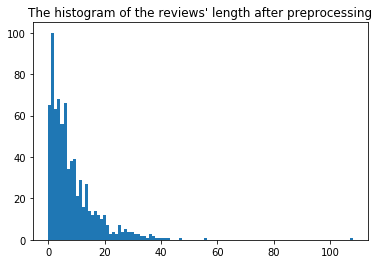

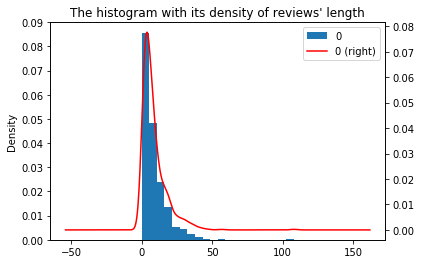

In [45]:
# distribution of review length after preprocessing
review_length = preproc_reviews.sum(axis=1)
length = review_length.A1.tolist()
length_df = pd.DataFrame(length)
#plt.subplot(1,2,1)
plt.hist(length, bins=100)
plt.title('The histogram of the reviews\' length after preprocessing')

ax = length_df.plot(kind='hist', bins=20, density=True)
length_df.plot(kind='kde', ax=ax, secondary_y=True, color='r')
plt.title('The histogram with its density of reviews\' length')
plt.show()# the distribution of the review length is much better

In [46]:
# common words from the reviews
words_sum = preproc_reviews.sum(axis=0)
counts_per_word = list(zip(pipe_cv.get_feature_names(), words_sum.A1))
sorted(counts_per_word, key=lambda t: t[1], reverse=True)[:20]

[('flashlight', 380),
 ('light', 363),
 ('pron', 321),
 ('bright', 292),
 ('great', 229),
 ('work', 198),
 ('battery', 197),
 ('good', 179),
 ('use', 165),
 ('small', 142),
 ('little', 113),
 ('price', 103),
 ('buy', 97),
 ('mode', 75),
 ('size', 75),
 ('time', 68),
 ('turn', 62),
 ('like', 61),
 ('love', 61),
 ('nice', 61)]

- Here, we obviously need to add some words from the above list into the stop words list to eliminate the influence made by these meaningless words. In this case, we would add **[flashlight, light, pron]** into the new stop words list.

In [47]:
# extend the stop-words list
stop_words_update = list(pipe_cv.get_stop_words())
stop_words_update.append('pron')
stop_words_update.append('aa')

In [48]:
stop_words_list = ['flashlight', 'light']
pipeline.set_params(posf__stop_words=stop_words_list, cv__stop_words=stop_words_update)

Pipeline(memory=None,
     steps=[('posf', PartOfSpeechFilter(pos_to_keep=('NOUN', 'PROPN', 'ADJ', 'VERB'),
          stop_words=['flashlight', 'light'])), ('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True...   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None))])

In [49]:
preproc_reviews = pipeline.fit_transform(review_body)
pipe_cv = pipeline.named_steps['cv']

In [50]:
# the most popular words which might contain useful information in the reviews
words_sum = preproc_reviews.sum(axis=0)
counts_per_word = list(zip(pipe_cv.get_feature_names(), words_sum.A1))
sorted(counts_per_word, key=lambda t: t[1], reverse=True)[:20]
# apperantly we need to update the stopwords list
# here I update 'aa' in the stopwords list

[('bright', 292),
 ('great', 229),
 ('work', 198),
 ('battery', 197),
 ('good', 179),
 ('use', 165),
 ('small', 142),
 ('little', 113),
 ('price', 103),
 ('buy', 97),
 ('mode', 75),
 ('size', 75),
 ('time', 68),
 ('turn', 62),
 ('like', 61),
 ('love', 61),
 ('nice', 61),
 ('pocket', 61),
 ('clip', 58),
 ('need', 55)]

### Then, we perform similar process to the review title.

In [51]:
preproc_titles = pipeline.fit_transform(review_title)
pipe_cv = pipeline.named_steps['cv']

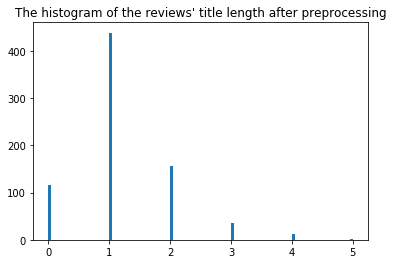

In [52]:
# length of the review title
review_length = preproc_titles.sum(axis=1)
length = review_length.A1.tolist()
length_df = pd.DataFrame(length)
plt.hist(length, bins=100)
plt.title('The histogram of the reviews\' title length after preprocessing')
plt.show() # most of the title actually contain one word which might deliver useful information.

In [53]:
title_sum = preproc_titles.sum(axis=0)
title_counts_per_word = list(zip(pipe_cv.get_feature_names(), title_sum.A1))
sorted(title_counts_per_word, key=lambda t: t[1], reverse=True)[:20]
# as it can be seen, the star should be in the stop word list

[('star', 240),
 ('great', 111),
 ('good', 68),
 ('bright', 67),
 ('little', 43),
 ('small', 40),
 ('work', 35),
 ('price', 33),
 ('buy', 32),
 ('quality', 24),
 ('nice', 22),
 ('battery', 18),
 ('lead', 17),
 ('love', 17),
 ('size', 16),
 ('product', 15),
 ('perfect', 14),
 ('like', 13),
 ('deal', 12),
 ('expect', 11)]

In [54]:
# then, we update the stop-words list to see the result
stop_words_update.append('star')
pipeline.set_params(posf__stop_words=stop_words_list, cv__stop_words=stop_words_update)

Pipeline(memory=None,
     steps=[('posf', PartOfSpeechFilter(pos_to_keep=('NOUN', 'PROPN', 'ADJ', 'VERB'),
          stop_words=['flashlight', 'light'])), ('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True...   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None))])

In [55]:
preproc_titles = pipeline.fit_transform(review_title)
pipe_cv = pipeline.named_steps['cv']

In [56]:
title_sum = preproc_titles.sum(axis=0)
title_counts_per_word = list(zip(pipe_cv.get_feature_names(), title_sum.A1))
sorted(title_counts_per_word, key=lambda t: t[1], reverse=True)[:]
# these are the important words in the title

[('great', 111),
 ('good', 68),
 ('bright', 67),
 ('little', 43),
 ('small', 40),
 ('work', 35),
 ('price', 33),
 ('buy', 32),
 ('quality', 24),
 ('nice', 22),
 ('battery', 18),
 ('lead', 17),
 ('love', 17),
 ('size', 16),
 ('product', 15),
 ('perfect', 14),
 ('like', 13),
 ('deal', 12),
 ('expect', 11),
 ('value', 11),
 ('awesome', 10),
 ('handy', 10),
 ('compact', 9),
 ('flash', 9),
 ('use', 9),
 ('powerful', 8)]

### Introducing a new variable, *fake_review*.
- After analysis, I decide to add a new variable as **possible_fake_review**.
- The variable will be ***1(positive)*** if the following conditions are satisfied at the same time, otherwise, it will be ***0(negative)***:
    1. The author of the review is **two-word name**.
    2. The length of the review is equal to **1**.
    3. The review title is **'Five Stars'**.
    4. The rate is **5**.

In [57]:
for i in range(len(review_df.review_body)):
    author = review_df.loc[i, 'author'].split()
    rate = review_df.loc[i, 'rate']
    title = review_df.loc[i, 'review_title']
    body = review_df.loc[i, 'review_body'].split()
    if len(author) ==2 and len(body) ==1 and title=='Five Stars' and rate == 5.0:
        review_df.loc[i, 'fake_review'] = 1
    else:
        review_df.loc[i, 'fake_review'] = 0

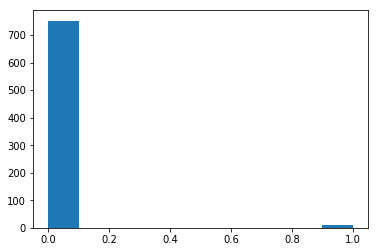

In [58]:
# see the histogram of the possible fake review.
plt.hist(review_df.fake_review)
plt.show()

## 1.4 EDA conclusion:
- Most of the rates are high point (i.e. 4 and 5).
- If there is image or video contained in the review, the rates are more possible to be a high point.
- Some fake reviews are existing in the dataset, and a new feature is created by combining several features as judgements.
- The length of the review are mainly between 1 word to 30 words with a short tail in the distribution.
- The review title often contains strong sentiment.
- Based on the above EDA, I decide to choose the following features to predict rating:
    - **image:** an image or video contained in the review or not.
    - **review format:** i.e. black, 4-pack, 6-pack.
    - **review title**
    - **review:** review body.
    - **fake review:** the new variable created through a series of conditions.

# 2. Preprocessing method:
- Feature Extraction from text: text as a bag-of-words, tf-idf

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
# split the data into training and test
training, test = train_test_split(review_df, test_size=0.2, random_state=233)
print(len(training), "train +", len(test), "test")

608 train + 153 test


In [61]:
# reindex
training.index = range(608)
test.index = range(153)
training.head()

,author,date,declarative,image,rate,review_body,review_format,review_title,fake_review
0,philip sinson,2017-09-25,Verified Purchase,False,1.0,does not work,Black,One Star,0.0
1,Bonecat,2017-07-17,Verified Purchase,False,4.0,The light is super Bright for its size. I am n...,Black,Rockbirds LED Flashlight,0.0
2,Rhonda,2017-06-03,Verified Purchase,False,5.0,"These are tiny, but mighty. I can keep one in ...",Black,Bright!,0.0
3,CJ,2017-12-31,Verified Purchase,False,5.0,"These are good to have everywhere, especially ...",Black,Handy with the clip on side,0.0
4,Edwin Y. Zhao,2017-03-23,Verified Purchase,False,5.0,Great quality for the price!,Black,Five Stars,0.0


## 2.1 Prepare X and y with TF-IDF and without TF-IDF
- The process is a little bit complicated
- The final data used for training and testing model is saved as:

|                |       | Train  |            | Test        |
| ---------------|-----------|----------|----------------|-----------------|
| Without TF-IDF |   **X**   |   **y**  |    **X_test**  | **y_test**      |
|  With TF-IDF   |**X_tfidf**|**y_tfidf**|**X_tfidf_test**| **y_tfidf_test**|

In [62]:
pipeline = Pipeline([('posf', PartOfSpeechFilter()),
                     ('cv', CountVectorizer())
                   ])
pipeline.set_params(cv__lowercase=True,cv__max_df=0.97, cv__min_df=0.01, cv__stop_words='english')
pipeline.set_params(posf__stop_words=stop_words_list, cv__stop_words=stop_words_update)
pipe_cv = pipeline.named_steps['cv']

In [63]:
# features: image, review_body, review_format, review_title, fake_review
image = training.loc[:, 'image']
review_format = training.loc[:,'review_format']
title_pre = training.loc[:,'review_title']
title = pipeline.fit_transform(title_pre)
title_feature_name = pipe_cv.get_feature_names()
body_pre = training.loc[:,'review_body']
body = pipeline.fit_transform(body_pre)
body_feature_name = pipe_cv.get_feature_names()
fake = training.loc[:, 'fake_review']
y = training.loc[:, 'rate']

In [64]:
def to_array_variabel(df, shape = (100,100)):
    to_array = pd.factorize(df)[0]
    #to_array = pd.DataFrame.as_matrix(df)
    var_array = np.reshape(to_array, shape)
    return var_array

In [65]:
image_array = to_array_variabel(image, (608,1))
format_array = to_array_variabel(review_format, (608,1))
fake_array = to_array_variabel(fake, (608,1))
# the order of the variables are image, formate, body, title, fake
X = np.hstack((image_array, format_array, body.toarray(), title.toarray(), fake_array))
X.shape

(608, 206)

In [66]:
variable_name = ['image_or_not', 'format_']+body_feature_name+title_feature_name+['fake_review']+['y']

In [67]:
df_CV = pd.DataFrame(X)
df_CV['y'] = y
df_CV.columns = variable_name
df_CV.head(10) # training set without tf-id

,image_or_not,format_,adjust,adjustable,amazing,awesome,backpack,bad,battery,beam,...,powerful,price,product,quality,size,small,value,work,fake_review,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
1,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,4.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
5,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,5.0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [68]:
image = test.loc[:, 'image']
review_format = test.loc[:,'review_format']
title_pre = training.loc[:,'review_title']
title = pipeline.fit_transform(title_pre)
title_pre_test = test.loc[:,'review_title']
title = pipeline.transform(title_pre_test)
body_pre_test = training.loc[:,'review_body']
body = pipeline.fit_transform(body_pre_test)
body_test_pre = test.loc[:,'review_body']
body = pipeline.transform(body_test_pre)
fake = test.loc[:, 'fake_review']
y_test = test.loc[:, 'rate']

In [69]:
image_array = to_array_variabel(image, (153,1))
format_array = to_array_variabel(review_format, (153,1))
fake_array = to_array_variabel(fake, (153,1))
# the order of the variables are image, formate, body, title, fake
X_test = np.hstack((image_array, format_array, body.toarray(), title.toarray(), fake_array))

In [70]:
df_CV_test = pd.DataFrame(X_test)
df_CV_test['y'] = y_test
df_CV_test.columns = variable_name
df_CV_test.head(10) # Test set without tf-idf

,image_or_not,format_,adjust,adjustable,amazing,awesome,backpack,bad,battery,beam,...,powerful,price,product,quality,size,small,value,work,fake_review,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,5.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,5.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
6,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,1,0,5.0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,4.0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0


In [71]:
# prepare tf-idf dataset

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
pipeline_tfidf = Pipeline([('posf', PartOfSpeechFilter()),
                     ('tfidf', TfidfVectorizer())
                   ])
pipeline_tfidf.set_params(posf__stop_words=stop_words_list, tfidf__lowercase=True, tfidf__max_df=0.95, 
                    tfidf__min_df=0.01, tfidf__stop_words=stop_words_update, tfidf__norm='l2', tfidf__use_idf=True)
pipe_tfidf_cv = pipeline_tfidf.named_steps['tfidf']

In [74]:
image = training.loc[:, 'image']
review_format = training.loc[:,'review_format']
title_pre = training.loc[:,'review_title']
title = pipeline_tfidf.fit_transform(title_pre)
title_feature_name = pipe_tfidf_cv.get_feature_names()
body_pre = training.loc[:,'review_body']
body = pipeline_tfidf.fit_transform(body_pre)
body_feature_name = pipe_tfidf_cv.get_feature_names()
fake = training.loc[:, 'fake_review']
y_tfidf = training.loc[:, 'rate']

In [75]:
image_array = to_array_variabel(image, (608,1))
format_array = to_array_variabel(review_format, (608,1))
fake_array = to_array_variabel(fake, (608,1))
# the order of the variables are image, formate, body, title, fake
X_tfidf = np.hstack((image_array, format_array, body.toarray(), title.toarray(), fake_array))
X_tfidf.shape

(608, 206)

In [76]:
variable_name = ['image_or_not', 'format_']+body_feature_name+title_feature_name+['fake_review']+['y']

In [77]:
training_tfidf = pd.DataFrame(X_tfidf)
training_tfidf['y'] = y_tfidf
training_tfidf.columns = variable_name
training_tfidf.head(10) #Training set with tf-idf

,image_or_not,format_,adjust,adjustable,amazing,awesome,backpack,bad,battery,beam,...,powerful,price,product,quality,size,small,value,work,fake_review,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.442841,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.397839,0.000000,0.0,...,0.0,0.61103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [78]:
image = test.loc[:, 'image']
review_format = test.loc[:,'review_format']
title_pre = training.loc[:,'review_title']
title = pipeline_tfidf.fit_transform(title_pre)
title_test_pre = test.loc[:,'review_title']
title = pipeline_tfidf.transform(title_test_pre)
body_pre = training.loc[:,'review_body']
body = pipeline_tfidf.fit_transform(body_pre)
body_test_pre = test.loc[:,'review_body']
body = pipeline_tfidf.transform(body_test_pre)
fake = test.loc[:, 'fake_review']
y_tfidf_test = test.loc[:, 'rate']

In [79]:
image_array = to_array_variabel(image, (153,1))
format_array = to_array_variabel(review_format, (153,1))
fake_array = to_array_variabel(fake, (153,1))
# the order of the variables are image, formate, body, title, fake
X_tfidf_test = np.hstack((image_array, format_array, body.toarray(), title.toarray(), fake_array))

In [80]:
test_tfidf = pd.DataFrame(X_tfidf_test)
test_tfidf['y'] = y_tfidf_test
test_tfidf.columns = variable_name
test_tfidf.head(10) # Test set with tf-idf

,image_or_not,format_,adjust,adjustable,amazing,awesome,backpack,bad,battery,beam,...,powerful,price,product,quality,size,small,value,work,fake_review,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.869841,0.0,0.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187049,0.0,...,0.0,0.0,0.0,0.0,0.0,0.802501,0.000000,0.0,0.0,5.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,5.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,4.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.581071,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,5.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,4.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.869841,0.0,0.0,4.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,5.0


# 3. Build the model

## 3.1 Logistic Regression

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
lr = LogisticRegression()
# the attribute of the function (default parameters)
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [83]:
np.random.seed(23)
training_test = pd.DataFrame(X)
index_training = np.random.choice(a=training_test.index, size=200, replace=False)
training_test_val = training_test.loc[index_training]
train_rate = pd.DataFrame(y)
labels = train_rate.loc[:,'rate']
labels_new = labels.reset_index(drop=True)
training_test_labels = labels_new.loc[index_training]

In [84]:
preproc_training_test = pd.DataFrame.as_matrix(training_test_val)

In [85]:
# the logistic regression accuracy score
lr.score(preproc_training_test, training_test_labels)

0.85

In [86]:
from sklearn.metrics import confusion_matrix

In [87]:
# check the confusion matrix
# it seems that many rates are predicted as 5 point, which generates the most of errors.
conf_matrix = confusion_matrix(training_test_labels, lr.predict(preproc_training_test), labels=[1,2,3,4,5])
conf_matrix

array([[ 15,   0,   0,   1,   2],
       [  3,   7,   0,   0,   3],
       [  2,   0,   7,   1,   6],
       [  2,   0,   0,  16,   8],
       [  0,   0,   0,   2, 125]])

- Changing parameters of the model as below

In [88]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [89]:
# using the default parameters of the logistic regression
lr = LogisticRegression(random_state=20)
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=20, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [90]:
scores = cross_validate(lr, X, y, cv=10, 
                        scoring=['accuracy'],
                        return_train_score=True
                       )
scores
# overfitting issue exists possibly

{'fit_time': array([0.01005363, 0.00858498, 0.00807476, 0.00856256, 0.00702   ,
        0.00695753, 0.00699592, 0.00662279, 0.00619936, 0.00597978]),
 'score_time': array([0.00047326, 0.0004499 , 0.00037885, 0.00041723, 0.00030971,
        0.00026083, 0.00038934, 0.0002389 , 0.00022125, 0.00021195]),
 'test_accuracy': array([0.62903226, 0.69354839, 0.72580645, 0.61290323, 0.64516129,
        0.66129032, 0.73770492, 0.66101695, 0.74576271, 0.71929825]),
 'train_accuracy': array([0.83699634, 0.84065934, 0.81868132, 0.84065934, 0.82967033,
        0.83150183, 0.8226691 , 0.8287796 , 0.82513661, 0.82577132])}

In [91]:
print ('The mean of test_accuracy of the model with the default hyperparameter:')
scores['test_accuracy'].mean()

The mean of test_accuracy of the model with the default hyperparameter:


0.6831524760147641

In [92]:
# Change some of the parameters to see how the model fits
lr2 = LogisticRegression(solver='saga', multi_class='multinomial', random_state=20, max_iter=1000)
lr2.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=20, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [93]:
scores = cross_validate(lr2, X, y, cv=10, 
                        scoring=['accuracy'],
                        return_train_score=True
                       )
scores

{'fit_time': array([0.85254455, 0.82071257, 0.46208239, 0.80652547, 0.85709667,
        0.86238384, 0.84772968, 0.87532139, 0.8224535 , 0.84816599]),
 'score_time': array([0.00037575, 0.00037456, 0.00030088, 0.00028396, 0.000386  ,
        0.00038433, 0.00037742, 0.00037885, 0.00037694, 0.00033617]),
 'test_accuracy': array([0.62903226, 0.69354839, 0.70967742, 0.59677419, 0.64516129,
        0.70967742, 0.75409836, 0.69491525, 0.72881356, 0.70175439]),
 'train_accuracy': array([0.87362637, 0.86630037, 0.86263736, 0.87362637, 0.86813187,
        0.86996337, 0.85740402, 0.86338798, 0.8579235 , 0.86206897])}

In [94]:
scores['test_accuracy'].mean()
# the accuracy hasn't changed at all.
# then, we are going to decide the best combination of the model

0.6863452527921907

In [95]:
from sklearn.model_selection import GridSearchCV

In [96]:
# hyperparameter combinations test
lr = LogisticRegression(random_state=20, max_iter=10000)
param_grid = { 'C': [1, 0.5, 5, 10,100], 'multi_class' : ['ovr','multinomial'], 'solver':['saga','newton-cg', 'lbfgs']}
grid = GridSearchCV(lr, param_grid=param_grid, cv=10, n_jobs=-1)

In [97]:
%%time
grid.fit(X, y)

CPU times: user 1.65 s, sys: 141 ms, total: 1.8 s
Wall time: 2min 34s


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=20, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 0.5, 5, 10, 100], 'multi_class': ['ovr', 'multinomial'], 'solver': ['saga', 'newton-cg', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [98]:
# the best parameters for the logistic regression is:
grid.best_params_

{'C': 1, 'multi_class': 'multinomial', 'solver': 'saga'}

In [99]:
# the finally logistic regression model:
grid.cv_results_['mean_test_score']

array([0.68256579, 0.68256579, 0.68256579, 0.68585526, 0.68585526,
       0.68585526, 0.68092105, 0.67927632, 0.67927632, 0.68421053,
       0.68421053, 0.68421053, 0.66282895, 0.66447368, 0.66447368,
       0.64473684, 0.64473684, 0.64473684, 0.64967105, 0.64802632,
       0.64802632, 0.63980263, 0.64473684, 0.64473684, 0.62664474,
       0.61513158, 0.61513158, 0.61677632, 0.61348684, 0.61348684])

- **Findings:**
- **68.58%** seems the best accuracy we can get from the logistic regression **without TF-IDF** method.
- Using the logistic regression method with **TF-IDF** for the preprocessing.

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [104]:
# hyperparameter combinations test
lr = LogisticRegression(random_state=20, max_iter=10000)
param_grid = { 'C': [1, 0.5, 5, 10,100], 'multi_class' : ['ovr', 'multinomial'], 'solver':['saga','newton-cg', 'lbfgs']}
grid_tfidf = GridSearchCV(lr, param_grid=param_grid, cv=10, n_jobs=-1)

In [105]:
%%time
grid_tfidf.fit(X_tfidf, y_tfidf)

CPU times: user 1.04 s, sys: 97.6 ms, total: 1.14 s
Wall time: 35.5 s


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=20, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 0.5, 5, 10, 100], 'multi_class': ['ovr', 'multinomial'], 'solver': ['saga', 'newton-cg', 'lbfgs']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
grid_tfidf.best_params_

{'C': 5, 'multi_class': 'ovr', 'solver': 'saga'}

In [107]:
grid_tfidf.cv_results_['mean_test_score']

array([0.66776316, 0.66776316, 0.66776316, 0.67269737, 0.67269737,
       0.67269737, 0.64309211, 0.64309211, 0.64309211, 0.64967105,
       0.64967105, 0.64967105, 0.67434211, 0.67434211, 0.67434211,
       0.65460526, 0.65460526, 0.65460526, 0.65625   , 0.65625   ,
       0.65625   , 0.63815789, 0.63815789, 0.63815789, 0.62171053,
       0.61842105, 0.61842105, 0.61842105, 0.61842105, 0.61842105])

- **Findings:**
- It seems we have a slightly worse result **(accuracy of 67.26%)** with the TF-IDF method than without TF-IDF method.
- But if the TF-IDF method is used, the algorithm can be much faster than without TF-IDF method. Especially, when the dataset is much larger, the time that an algorithm consumes will be an important issue to consider. 
- And it's very possible we have overfitting issue here. Because the results from cross validation are significantly less than using the train_test data.

## 3.2 SVM model

In [108]:
from sklearn.svm import SVC

In [109]:
# fit svc model with default hyperparameters by using tf-idf preprocessing
svc = SVC()
scores = cross_validate(svc, X_tfidf, y_tfidf, cv=10, n_jobs=-1, return_train_score=True)
print ('The mean of test_accuracy of the model with the default hyperparameter of SVC model:')
scores['test_score'].mean()

The mean of test_accuracy of the model with the default hyperparameter of SVC model:


0.640223837565393

In [110]:
# find the best combination of the hyperparameters
svc = SVC(random_state=20)
param_grid = { 'C': [1, 0.5, 5, 10,100], 'decision_function_shape':['ovo', 'ovr'], 'kernel':['linear', 'rbf']}
grid_svc = GridSearchCV(svc, param_grid=param_grid, cv=10, n_jobs=-1)

In [111]:
%%time
# fit with non-tfidf dataset
grid_svc.fit(X, y)

CPU times: user 400 ms, sys: 76.7 ms, total: 476 ms
Wall time: 4.37 s


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=20, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 0.5, 5, 10, 100], 'decision_function_shape': ['ovo', 'ovr'], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [112]:
grid_svc.best_params_

{'C': 0.5, 'decision_function_shape': 'ovo', 'kernel': 'linear'}

In [113]:
grid_svc.cv_results_['mean_test_score']

array([0.64144737, 0.63980263, 0.64144737, 0.63980263, 0.68092105,
       0.63980263, 0.68092105, 0.63980263, 0.59868421, 0.65625   ,
       0.59868421, 0.65625   , 0.60526316, 0.66447368, 0.60526316,
       0.66447368, 0.55592105, 0.64638158, 0.55592105, 0.64638158])

In [114]:
%%time
# fit tfidf dataset
grid_svc.fit(X_tfidf, y_tfidf)

CPU times: user 442 ms, sys: 95.7 ms, total: 538 ms
Wall time: 4.9 s


GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=20, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 0.5, 5, 10, 100], 'decision_function_shape': ['ovo', 'ovr'], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [115]:
grid_svc.best_params_

{'C': 100, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}

In [116]:
grid_svc.cv_results_['mean_test_score']

array([0.68092105, 0.63980263, 0.68092105, 0.63980263, 0.67434211,
       0.63980263, 0.67434211, 0.63980263, 0.61842105, 0.63980263,
       0.61842105, 0.63980263, 0.59375   , 0.63980263, 0.59375   ,
       0.63980263, 0.55592105, 0.68256579, 0.55592105, 0.68256579])

- It seems we have a slightly worse result than the logistic regression model.
- All the models that we used didn't get good results but very similar result ( accuracy around 65%-68%, it varies from time to time ). Maybe it is because we are using **too many features** and some of the words in review are not very usefull which might introduce **noisy** instead.
- The next step is to use the test data we saved before to test the models. Here, we will only test the logistic regession and SVC model with **TF-IDF preprocessing**.

## 3.3 Comparing different algorithms:

### The final step is to test the models I used before to see which one is better for the test data set.

In [117]:
test.head()

,author,date,declarative,image,rate,review_body,review_format,review_title,fake_review
0,Rick Casey,2017-05-18,Verified Purchase,False,5.0,"These are Great, Small, and Bright flashlights...",Black,Great Value Flashlights,0.0
1,John M,2017-05-18,Verified Purchase,False,5.0,Very bright and compact,Black,Five Stars,0.0
2,Aaron,2017-08-31,Verified Purchase,False,5.0,A must for everyone. Works very well,Black,Five Stars,0.0
3,Brittney Peebles,2017-03-30,Verified Purchase,False,5.0,My husband works in the oilfield so I grabbed ...,Black,Great small flashlight,0.0
4,butta yehonatan yaakove,2017-10-25,Verified Purchase,False,5.0,very good,Black,Five Stars,0.0


In [118]:
# logistic regression without tfidf
#%%time
lr1 = LogisticRegression(random_state=20, max_iter=10000, C=0.5, multi_class= 'ovr', solver= 'saga')
lr1.fit(X, y)
lr1.score(X_test, y_test)

0.6928104575163399

In [119]:
conf_matrix = confusion_matrix(y_test, lr1.predict(X_test), labels=[1,2,3,4,5])
conf_matrix

array([[ 5,  0,  1,  1,  4],
       [ 1,  0,  0,  3,  4],
       [ 1,  0,  0,  1,  8],
       [ 0,  0,  0,  2, 18],
       [ 3,  1,  0,  1, 99]])

In [120]:
# logistic regression with tfidf
#%%time
lr2 = LogisticRegression(random_state=20, max_iter=10000, C= 1, multi_class='ovr', solver='saga')
lr2.fit(X_tfidf, y_tfidf)
lr2.score(X_tfidf_test, y_tfidf_test)

0.6862745098039216

In [121]:
conf_matrix = confusion_matrix(y_tfidf_test, lr2.predict(X_tfidf_test), labels=[1,2,3,4,5])
conf_matrix

array([[  3,   0,   1,   2,   5],
       [  1,   0,   0,   1,   6],
       [  1,   0,   0,   0,   9],
       [  0,   0,   0,   0,  20],
       [  2,   0,   0,   0, 102]])

In [122]:
# SVC with tfidf
svc = SVC(random_state=20, C=10, decision_function_shape='ovo', kernel= 'rbf')
svc.fit(X_tfidf, y_tfidf)
svc.score(X_tfidf_test, y_tfidf_test)

0.6797385620915033

In [124]:
conf_matrix = confusion_matrix(y_tfidf_test, svc.predict(X_tfidf_test), labels=[1,2,3,4,5])
conf_matrix # this is very bad, all results are classified as 5 point.

array([[  0,   0,   0,   0,  11],
       [  0,   0,   0,   0,   8],
       [  0,   0,   0,   0,  10],
       [  0,   0,   0,   0,  20],
       [  0,   0,   0,   0, 104]])

# 4. Algorithm analysis:
- The better mothod to choose: **Logistic Regression**
    1. In this case, the logistic regression method (without tf-idf) gives a better prediction accuracy of the rating.
    2. SVM works better when the number of features is much larger than the number of samples, but the number of features is not large enough. This is the main reason why the SVM doesn't work well in this case.
    3. It seems that there is a linear decision boundary existing among different classes.

# 5. Attachment (Other methods):
- There are some other techniques that I tried to improve the accuracy of the model. Unfortunately, they didn't provide better perfomance for some reason. I just attached the method I tried to give simple donmenstration of their performance. 

### 1. SMOTE 
- SMOTE is an oversampling method. 
- It works by creating synthetic samples from the minor class instead of creating copies. 

In [125]:
from imblearn.over_sampling import SMOTE

In [126]:
sm = SMOTE(random_state=12, ratio = 'auto')
x_res, y_res = sm.fit_sample(X_tfidf, y_tfidf)

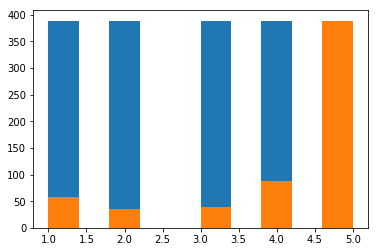

In [127]:
# show the oversampled dataset. Now, we have balanced sample.
plt.hist(y_res)
plt.hist(y)
plt.show()

In [128]:
# test the resample dataset
svc = SVC(random_state=20, C=10, decision_function_shape='ovo', kernel= 'rbf')
svc.fit(x_res, y_res)
scores = cross_validate(svc, x_res, y_res, cv=10, n_jobs=-1, return_train_score=True)

In [129]:
scores
# it works very good on the training dataset, even by using cross validation
# it even reach a accuracy of 87%

{'fit_time': array([1.19377184, 1.16960812, 1.15693593, 1.22996664, 1.22544718,
        1.22238016, 1.20991015, 1.17514181, 0.89420748, 0.89992166]),
 'score_time': array([0.1293385 , 0.12776065, 0.12254834, 0.14433289, 0.14707589,
        0.1512239 , 0.14825201, 0.13623571, 0.07862902, 0.0784297 ]),
 'test_score': array([0.66666667, 0.77948718, 0.83589744, 0.77435897, 0.75384615,
        0.82564103, 0.77435897, 0.76923077, 0.82051282, 0.78421053]),
 'train_score': array([0.83542857, 0.82228571, 0.81828571, 0.81657143, 0.816     ,
        0.81142857, 0.81771429, 0.804     , 0.816     , 0.81538462])}

In [130]:
# try on the test data, however, the result not very good
# reason might be overfitting
svc.score(X_tfidf_test, y_tfidf_test)

0.5555555555555556

In [131]:
conf_matrix = confusion_matrix(y_tfidf_test, svc.predict(X_tfidf_test), labels=[1,2,3,4,5])
conf_matrix
# but the model doesn't blindly predict all the result as class 5 (not like the previous SVC method)
# if we reduce the number of class, let's say 3 classes (or even 2), this would give a better performance
# SMOTE method is a good way to handle the imbalanced dataset, but we have a multiclass dataset, 
# so it might be the reason the method not working

array([[ 7,  2,  0,  2,  0],
       [ 5,  0,  1,  2,  0],
       [ 4,  2,  1,  1,  2],
       [ 2,  3,  1, 10,  4],
       [ 6,  3,  7, 21, 67]])

### 2. Feature Selection
- There are many 206 features used in the model.
- As I mentioned before, it's very possible that we have the overfitting issue in the model.
- Using the sklearn's feature selection function to try to reduce the dimention of the model.

In [132]:
from sklearn.feature_selection import SelectFromModel

In [142]:
# model from previous logistic regression
lr2 = LogisticRegression(random_state=20, max_iter=10000, C= 1, multi_class='ovr', solver='saga')
lr2.fit(X_tfidf, y_tfidf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=20, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [143]:
model = SelectFromModel(lr2, prefit=True)
index_smote = model.get_support()

In [144]:
X_new = model.transform(X_tfidf)

In [145]:
X_new.shape
# the number of features has been reduced significantly, now only 86 features

(608, 86)

In [147]:
lr2.fit(X_new, y_tfidf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=20, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [148]:
scores = cross_validate(lr2, X_new, y_tfidf, cv=10, 
                        scoring=['accuracy'],
                        return_train_score=True
                       )
scores # the results are pretty much the same as before

{'fit_time': array([0.06875324, 0.05291128, 0.05309749, 0.05235982, 0.05301595,
        0.05394053, 0.05445027, 0.05416203, 0.05286527, 0.0658052 ]),
 'score_time': array([0.00029874, 0.00019503, 0.00018668, 0.00018954, 0.00020599,
        0.00023484, 0.00019145, 0.00018692, 0.00018668, 0.00045395]),
 'test_accuracy': array([0.64516129, 0.62903226, 0.67741935, 0.64516129, 0.64516129,
        0.69354839, 0.68852459, 0.6440678 , 0.69491525, 0.70175439]),
 'train_accuracy': array([0.70695971, 0.6996337 , 0.70879121, 0.71794872, 0.71245421,
        0.7014652 , 0.69652651, 0.71038251, 0.70491803, 0.71506352])}

In [157]:
# reduce the dimension of the feature for the test data
X_new = test_tfidf.loc[:207]
new_x = X_new.iloc[:,index_smote]
new_y = test_tfidf['y']

In [158]:
new_x.head()

,format_,adjust,awesome,bad,battery,break,bright,button,buy,cap,...,little,love,make,nice,perfect,price,quality,small,work,fake_review
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.240136,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.475015,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.187049,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.802501,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [160]:
lr2.score(new_x, new_y) # the result hasn't improved

0.6797385620915033

In [161]:
conf_matrix = confusion_matrix(new_y, lr2.predict(new_x), labels=[1,2,3,4,5])
conf_matrix # most of the results are classified as 5 point
# after comparing other models with the previous ones,
# it turns out that reducing the number of features did not improve the result

array([[  3,   0,   0,   1,   7],
       [  0,   0,   0,   1,   7],
       [  1,   0,   0,   0,   9],
       [  0,   0,   0,   0,  20],
       [  3,   0,   0,   0, 101]])